# Final Project - Beat the Bookies

## Day One - Initial Data Exploration

The goal of today is:

- Create repositories
- Add collaborators
- Add notebooks to the project
- Confirm primary data source
- Build a dataframe that includes all the relevant and desired data from our model (check google sheets for the columns). 


Using the dataset downloaded from kaggle (https://www.kaggle.com/hugomathien/soccer?) - exploring the data available for one season (2015/16) to combine the data into our own dataframe that includes the relevant information that we need for our models.

Colummns for the dataset:

- Home Team Rank
- Home Team Total Wins
- Home Team win
- Draw
- Away Team Win
- Away Team Rank

To add columns including possesion, reds, yellows, corners, shots at goal, shots on target, goal percentage, throw ins (?), fouls, free kicks. Later on when we know that we can combine the core of the table easily for all seasons.

Target:
- Home Team win y/n

### imports 

In [ ]:
import pandas as pd
import numpy as np 
import sqlite3

### importing the data from sqlite

In [ ]:
# create the file path (include two beatthebookies)
path = '/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/database.sqlite'
# create the connection
conn = sqlite3.connect(path)
# create the cursor
cursor = conn.cursor()

In [ ]:
# from the match table we want to select all matches played in the English Premier league for the 2015/16 season.
# Premier League - league_id = 1729
# order by stages (Game Weeks)
# need quotes around '2015/2016'
result = cursor.execute(""" SELECT * FROM "Match" m 
                        WHERE league_id = 1729 
                        AND season = '2015/2016' 
                        ORDER BY stage ASC""")

In [ ]:
row = result.fetchall()
row[0] # seems to be a lot of null values for shots, s

In [ ]:
# create a DataFrame from the SQL query
matches_df = pd.read_sql(""" SELECT * FROM "Match" m 
                        WHERE league_id = 1729 
                        AND season = '2015/2016' 
                        ORDER BY stage ASC""", conn)

In [ ]:
# inspect the DataFrame
matches_df.columns.values

In [ ]:
# we can remove all the ones not needed for home-away goal data
simple_matches = matches_df.drop(['home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2',
       'away_player_X3', 'away_player_X4', 'away_player_X5',
       'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
       'home_player_Y10', 'home_player_Y11', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'away_player_Y8', 'away_player_Y9', 'away_player_Y10',
       'away_player_Y11', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11', 'away_player_1',
       'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
       'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
       'away_player_10', 'away_player_11', 'goal', 'shoton', 'shotoff',
       'foulcommit', 'card', 'cross', 'corner', 'possession', 'B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
       'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH',
       'BSD', 'BSA'], axis=1)

In [ ]:
simple_matches.head(5)

In [ ]:
simple_matches['home_goals']= simple_matches.groupby('home_team_api_id')['home_team_goal'].cumsum().fillna(0)

In [ ]:
simple_matches['away_goals']= simple_matches.groupby('away_team_api_id')['away_team_goal'].cumsum().fillna(0)

In [ ]:
simple_matches

In [ ]:
simple_matches.info()

In [ ]:
simple_matches['home_wins'] = simple_matches.home_team_goal > simple_matches.away_team_goal
simple_matches['draws'] = simple_matches.home_team_goal == simple_matches.away_team_goal
simple_matches['away_wins'] = simple_matches.home_team_goal < simple_matches.away_team_goal
simple_matches

In [ ]:
# convert booleans into binary numbers 
simple_matches['home_wins'] = simple_matches['home_wins'].astype(int)
simple_matches['draws'] = simple_matches['draws'].astype(int)
simple_matches['away_wins'] = simple_matches['away_wins'].astype(int)


In [ ]:
simple_matches.head()

In [ ]:
# create cumulative home, draw and away wins grouping by each team id

simple_matches['cumulative_home_wins_home'] = simple_matches.groupby('home_team_api_id')['home_wins'].cumsum().fillna(0)
simple_matches['cumulative_away_wins_home'] = simple_matches.groupby('home_team_api_id')['home_wins'].cumsum().fillna(0)
simple_matches['cumulative_home_wins_away'] = simple_matches.groupby('away_team_api_id')['away_wins'].cumsum().fillna(0)
# simple_matches['cumulative_draws'] = simple_matches.groupby('home_team_api_id')['draws'].cumsum().fillna(0)
simple_matches['cumulative_away_wins_away'] = simple_matches.groupby('away_team_api_id')['away_wins'].cumsum().fillna(0)


In [ ]:
simple_matches.tail(20)

## Day Two - Comparing bets (2015/2016)

The goal of today is to find a baseline betting profit and loss for our model to compare with.

From the data set we are going to look at the odds offered by the betting firm Ladbrokes on home win, away win and draw.

- Placing a ten pound bet on the favourite (team with lowest odds).
- Placing a ten pound bet on the Home team every time.
- Placing a ten pound bet on a draw every match.
- placing a ten pound bet on the underdog (team with highest odds).
- placing a ten pound bet on the away team.

Maximum loss is the ten pound stake - so after 380 matches worst case scenario is **£3800 down**. 


### Import the betting data

In [ ]:
import pandas as pd
import numpy as np 
import sqlite3

In [ ]:
# create the file path (include two beatthebookies)
path = '/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/database.sqlite'
# create the connection
conn = sqlite3.connect(path)
# create the cursor
cursor = conn.cursor()

In [ ]:
# use joining tables to keep the team names for better clarity
matches = pd.read_sql("""SELECT m.id, 
                        m.season, m.stage, m.date, 
                        ht.team_long_name as home_team, at.team_long_name as away_team, m.home_team_goal, 
                        m.away_team_goal, LBH, LBD, LBA                                      
                        FROM Match as m
                        LEFT JOIN Team AS ht on ht.team_api_id = m.home_team_api_id
                        LEFT JOIN Team AS at on at.team_api_id = m.away_team_api_id
                        WHERE league_id = 1729 AND season = '2015/2016'
                        ;""", conn)

In [ ]:
# sort matches in to cronological order
matches.sort_values('date', inplace=True)

In [ ]:
# check correctly imported the required data
matches.head()

In [ ]:
# create booleans
matches['home_win'] = matches.home_team_goal > matches.away_team_goal
matches['draw'] = matches.home_team_goal == matches.away_team_goal
matches['away_win'] = matches.home_team_goal < matches.away_team_goal

In [ ]:
# convert booleans into binary numbers 
matches['home_win'] = matches['home_win'].astype(int)
matches['draw'] = matches['draw'].astype(int)
matches['away_win'] = matches['away_win'].astype(int)

### Profit from betting on favourite

In [ ]:
matches['fav_profit'] = -10

In [ ]:
matches.head()

In [ ]:
matches.loc[(matches[['LBH','LBD','LBA']].min(axis=1) == matches['LBH']) & (matches['home_win'] == 1), 'fav_profit'] = matches['LBH'] * 10
matches.loc[(matches[['LBH','LBD','LBA']].min(axis=1) == matches['LBD']) & (matches['draw'] == 1), 'fav_profit'] = matches['LBD'] * 10
matches.loc[(matches[['LBH','LBD','LBA']].min(axis=1) == matches['LBA']) & (matches['away_win'] == 1), 'fav_profit'] = matches['LBA'] * 10


In [ ]:
matches

### Profit betting on Underdog

In [ ]:
matches['dog_profit'] = -10

In [ ]:
matches.loc[(matches[['LBH','LBD','LBA']].max(axis=1) == matches['LBH']) & (matches['home_win'] == 1), 'dog_profit'] = matches['LBH'] * 10
matches.loc[(matches[['LBH','LBD','LBA']].max(axis=1) == matches['LBD']) & (matches['draw'] == 1), 'dog_profit'] = matches['LBD'] * 10
matches.loc[(matches[['LBH','LBD','LBA']].max(axis=1) == matches['LBA']) & (matches['away_win'] == 1), 'dog_profit'] = matches['LBA'] * 10

In [ ]:
matches.head()

### Profit from Home / Draw / Away

In [ ]:
matches['home_profit'] = -10

In [ ]:
matches.loc[(matches['home_win'] == 1), 'home_profit'] = matches['LBH'] * 10 

In [ ]:
matches['draw_profit'] = -10

In [ ]:
matches.loc[(matches['draw'] == 1), 'draw_profit'] = matches['LBD'] * 10 

In [ ]:
matches['away_profit'] = -10

In [ ]:
matches.loc[(matches['away_win'] == 1), 'away_profit'] = matches['LBA'] * 10 

In [ ]:
matches.sort_values('date', inplace=True)

In [ ]:
matches

### Cumulative profit totals for each strategey

In [ ]:
# define a function that returns the maximum profit from each strategy
def c_profits(X):
    fav_profit_cum = X['fav_profit'].sum()
    dog_profit_cum = X['dog_profit'].sum()
    home_profit_cum = X['home_profit'].sum()
    draw_profit_cum = X['draw_profit'].sum()
    away_profit_cum = X['away_profit'].sum()
    return fav_profit_cum, dog_profit_cum, home_profit_cum,draw_profit_cum, away_profit_cum

In [ ]:
matches['away_profit'].cumsum().tail(1)

In [ ]:
c_profits(matches)

Very surpising that the underdog approach was the most profitable method of betting in this season but this was the year that Leicester City won the league. 

### Reorganise methods into functions to apply to all the data

In [ ]:
# psuedo code
# import the data using get_data():
# this returns a table with home_w, away_w and draw already added so need to add the boolean and conversion.
# first function favourites method
# second function is underdog 
# third is home team 
# fourth is draw
# fifth allways bet away. 

In [ ]:
def pick_the_fav(X, season, bet=10):
    """
    function returns a dataframe that includes the weekly profit/loss for season followng the favourites strategy
    """
    # set defaults profit equal to bet size
    X['fav_profit'] = -bet
    # update profit column
    X.loc[(matches[['LBH','LBD','LBA']].min(axis=1) == X['LBH']) & (X['home_w'] == 1), 'fav_profit'] = X['LBH'] * 10
    X.loc[(matches[['LBH','LBD','LBA']].min(axis=1) == X['LBD']) & (X['draw'] == 1), 'fav_profit'] = X['LBD'] * 10
    X.loc[(matches[['LBH','LBD','LBA']].min(axis=1) == X['LBA']) & (X['away_w'] == 1), 'fav_profit'] = X['LBA'] * 10
    
    return X

In [ ]:
def pick_the_dog(X, season, bet=10):
    """
    function returns a dataframe that includes the weekly profit/loss for season followng the underdog strategy
    """
    # set defaults profit equal to bet size
    X['dog_profit'] = -bet
    # update profit column 
    X.loc[(matches[['LBH','LBD','LBA']].max(axis=1) == X['LBH']) & (X['home_w'] == 1), 'dog_profit'] = X['LBH'] * 10
    X.loc[(matches[['LBH','LBD','LBA']].max(axis=1) == X['LBD']) & (X['draw'] == 1), 'dog_profit'] = X['LBD'] * 10
    X.loc[(matches[['LBH','LBD','LBA']].max(axis=1) == X['LBA']) & (X['away_w'] == 1), 'dog_profit'] = X['LBA'] * 10
    
    return X

In [ ]:
def always_home(X, season, bet=10):
    """
    function returns a dataframe that includes the weekly profit/loss for season following the home team strategy
    """
    X['home_profit'] = -bet
    X.loc[(X['home_w'] == 1), 'home_profit'] = X['LBH'] * 10 
    
    return X

In [ ]:
def always_draw(X, season, bet=10):
    """
    function returns a dataframe that includes the weekly profit/loss for season following the home team strategy
    """
    X['draw_profit'] = -bet
    X.loc[(X['draw'] == 1), 'draw_profit'] = X['LBH'] * 10 
    
    return X

In [ ]:
def always_away(X, season, bet=10):
    """
    function returns a dataframe that includes the weekly profit/loss for season following the home team strategy
    """
    X['away_profit'] = -bet
    X.loc[(X['away_w'] == 1), 'away_profit'] = X['LBH'] * 10 
    
    return X

### test functions

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from beatthebookies.data import get_betting_data, get_data

In [ ]:
def get_betting_data(season='2015/2016', league=1729, local=False, optimize=False, **kwargs):
    path = "../data/"
    database = path + 'database.sqlite'
    conn = sqlite3.connect(database)

    df = pd.read_sql("""SELECT m.id,
                            m.season, m.stage, m.date,
                            ht.team_long_name as home_team, at.team_long_name as away_team, m.home_team_goal,
                            m.away_team_goal, m.LBH, m.LBD, m.LBA 
                            FROM Match as m
                            LEFT JOIN Team AS ht on ht.team_api_id = m.home_team_api_id
                            LEFT JOIN Team AS at on at.team_api_id = m.away_team_api_id
                            WHERE league_id = :league AND season = :season
                            ;""", conn, params={"league":league, "season":season})
    # add win columns
    df['home_w'] = 0
    df['away_w'] = 0
    df['draw'] = 0
    # set winner
    df.loc[df['home_team_goal'] > df['away_team_goal'], 'home_w'] = 1
    df.loc[df['home_team_goal'] < df['away_team_goal'], 'away_w'] = 1
    df.loc[df['home_team_goal'] == df['away_team_goal'], 'draw'] = 1
    # sort into order
    df.sort_values('date', inplace=True)

    return df

In [ ]:
betting = get_data()

In [ ]:
betting.info()

In [ ]:
def simple_betting_profits(df, bet=10):
    """
    function returns the cumulative profits/loss from a season of following a consistent, simple betting strategy.
    """
    # set defaults profit equal to bet size
    # create new column for fav strategy
    df['fav_profit'] = -bet
    # update profit column
    df.loc[(df[['LBH','LBD','LBA']].min(axis=1) == df['LBH']) & (df['home_w'] == 1), 'fav_profit'] = (df['LBH'] * bet) - bet
    df.loc[(df[['LBH','LBD','LBA']].min(axis=1) == df['LBD']) & (df['draw'] == 1), 'fav_profit'] = (df['LBD'] * bet) - bet
    df.loc[(df[['LBH','LBD','LBA']].min(axis=1) == df['LBA']) & (df['away_w'] == 1), 'fav_profit'] = (df['LBA'] * bet) - bet

    # set defaults profit equal to bet size
    # create new column for underdog strategy
    df['dog_profit'] = -bet
    # update profit column
    df.loc[(df[['LBH','LBD','LBA']].max(axis=1) == df['LBH']) & (df['home_w'] == 1), 'dog_profit'] = (df['LBH'] * bet) - bet
    df.loc[(df[['LBH','LBD','LBA']].max(axis=1) == df['LBD']) & (df['draw'] == 1), 'dog_profit'] = (df['LBD'] * bet) - bet
    df.loc[(df[['LBH','LBD','LBA']].max(axis=1) == df['LBA']) & (df['away_w'] == 1), 'dog_profit'] = (df['LBA'] * bet) - bet

    # create new column for home team method
    df['home_profit'] = -bet
    df.loc[(df['home_w'] == 1), 'home_profit'] = (df['LBH'] * bet) - bet
    # create new column for draw tactic
    df['draw_profit'] = -bet
    df.loc[(df['draw'] == 1), 'draw_profit'] = (df['LBD'] * bet) - bet
    # create new column for betting on the away team
    df['away_profit'] = -bet
    df.loc[(df['away_w'] == 1), 'away_profit'] = (df['LBA'] * bet) - bet

    fav_profit_total = df['fav_profit'].sum()
    dog_profit_total = df['dog_profit'].sum()
    home_profit_total = df['home_profit'].sum()
    draw_profit_total = df['draw_profit'].sum()
    away_profit_total = df['away_profit'].sum()

    return fav_profit_total, dog_profit_total, home_profit_total, draw_profit_total, away_profit_total


In [ ]:
simple_betting_profits(betting)

## Day Three - Ternery outputs and introducing additional Data

In [ ]:
import pandas as pd
import numpy as np 
import sqlite3

In [ ]:
# create the file path (include two beatthebookies)
path = '/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/database.sqlite'
# create the connection
conn = sqlite3.connect(path)
# create the cursor
cursor = conn.cursor()

In [ ]:
# use joining tables to keep the team names for better clarity
matches = pd.read_sql("""SELECT m.id, 
                        m.season, m.stage, m.date, 
                        ht.team_long_name as home_team, at.team_long_name as away_team, m.home_team_goal, 
                        m.away_team_goal, LBH, LBD, LBA, goal, shoton, shotoff, foulcommit, card, 
                        cross, corner, possession                                      
                        FROM Match as m
                        LEFT JOIN Team AS ht on ht.team_api_id = m.home_team_api_id
                        LEFT JOIN Team AS at on at.team_api_id = m.away_team_api_id
                        WHERE league_id = 1729 AND season = '2015/2016'
                        ;""", conn)

In [ ]:
matches.head()

From here we have concluded not to use the Kaggle dataset for the match stats instead we will compile a complete data frame from 10 seperate csv files downloaded from https://www.football-data.co.uk

In [ ]:
# load all csv files as dataframes
df = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2008.csv")
df2 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2009.csv")
df3 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2010.csv")
df4 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2011.csv")
df5 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2012.csv")
df6 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2013.csv")
df7 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2014.csv")
df8 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2015.csv")
df9 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2016.csv")
df10 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2017.csv")
df11 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2018.csv")
df12 = pd.read_csv("/Users/georgebrockman/code/georgebrockman/Premier League CSV/premierleague2019.csv")

In [ ]:
# issues combining all at once so combine individually
combin_df = pd.concat([df,df2])
combin_df.reset_index(drop=True, inplace=True)

In [ ]:
# 2008-2010 dataset
temp = pd.concat([combin_df, df3])
temp.reset_index(drop=True, inplace=True)
temp

In [ ]:
# 2008-2011
tmp = pd.concat([temp, df4])
tmp.reset_index(drop=True, inplace=True)
tmp

In [ ]:
# create a merged csv for seasons 2008-2011 
tmp.to_csv( "combined_csv.csv", index=True, encoding='utf-8-sig')

In [ ]:
# 2012-2013 season merge
tmp1 = pd.concat([df5, df6])
tmp1.reset_index(drop=True, inplace=True)
tmp1

In [ ]:
# each csv has different values so need to drop columns that arn't in the kaggle dataset.
len(df.columns.values)

In [ ]:
df.head(20)

In [ ]:
df2.columns.values # GBH GBD GBA - GAMEBOOKERS

## Convert CSV Files to Relevant Columns and Combine

In [ ]:
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df2 = df2[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df3 = df3[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df4 = df4[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df5 = df5[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df6 = df6[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df7 = df7[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df8 = df8[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df9 = df9[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df10 = df10[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']]

In [ ]:
df11 = df11[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR','WHH', 'WHD', 'WHA']]

In [ ]:
df12 = df12[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF',
       'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'WHH', 'WHD', 'WHA']] 

In [ ]:
match_stats = pd.concat([df,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12])
match_stats.reset_index(drop=True, inplace=True)
match_stats

In [ ]:
# create the data frame
match_stats.to_csv( "premierleaguematches.csv", index=True, encoding='utf-8-sig')

### Add Seasons column to premierleaguematches.csv file 

In [ ]:
# import the csv file 
df = pd.read_csv('/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/notebooks/premierleaguematches.csv')

In [ ]:
# rename the unamed column to season
df.rename({'Unnamed: 0': 'Season'}, axis=1, inplace=True)

In [ ]:
# row 2660 had NaN values after combining the 12 CSV files - drop row so seasons stay correct
df.drop([2660], axis=0, inplace=True)

In [ ]:
# reset index
df.reset_index(drop=True, inplace=True)

In [ ]:
# update season values using multiples of 380
df.loc[0:379, 'Season'] = '2008/2009'

In [ ]:
df.loc[380:759, 'Season'] = '2009/2010'

In [ ]:
df.loc[760:1139, 'Season'] = '2010/2011'

In [ ]:
df.loc[1140:1519, 'Season'] = '2011/2012'

In [ ]:
df.loc[1520:1899, 'Season'] = '2012/2013'

In [ ]:
df.loc[1900:2279, 'Season'] = '2013/2014'

In [ ]:
df.loc[2280:2659, 'Season'] = '2014/2015'

In [ ]:
df.loc[2660:3039, 'Season'] = '2015/2016'

In [ ]:
df.loc[3040:3419, 'Season'] = '2016/2017'

In [ ]:
df.loc[3420:3799, 'Season'] = '2017/2018'

In [ ]:
df.loc[3800:4179, 'Season'] = '2018/2019'

In [ ]:
df.loc[4180:4560, 'Season'] = '2019/2020'

In [ ]:
# check its worked
df.Season.unique()

In [ ]:
# write csv file and push to git 
df.to_csv( "premierleague.csv", index=True, encoding='utf-8-sig')

## Day Four - Scrapping Fifa Stats for 2008, 2012, 2016-2019

Aim of today is to collect the fifa stats from the kaggle dataset from the missing seasons, add them to the newly created match stats csv file, ready for merging with our kaggle dataset that our model has already been working on.

exploring different scraping options but failure to get anywhere may result in an attempt to use Beautiful Soup Library as a last resort...

In [ ]:
import pandas as pd 
import numpy as np

In [ ]:
from beatthebookies.data import get_data, get_rankings

In [ ]:
data = get_data()

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
data.head()

Chris took over the webscrapping and smashed it!

### Comparison of team names in csv file and fifa ratings

In [ ]:
path = '../data/fifarank.csv'
df = pd.read_csv(path)
df.Team.unique()

In [ ]:
matches = pd.read_csv('/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/premierleague.csv')

In [ ]:
matches.HomeTeam.unique()

Names needing a change:
- Man United >> Manchester United
- Arsenal >> in some its Arsenal FC
- Chelsea >> in some its Chelsea FC
- Bolton >> Bolton Wanderers
- Hull >> Hull City
- West Ham >> West Ham United
- Blackburn >> Blackburn Rovers
- Newcastle >> Newcastle United
- Stoke >> Stoke City
- Tottenham >> Tottenham Hotspur
- West Brom >> West Bromwich >> West Bromwich Albion # this one has two alterations will need to change the other csv fil first
- Man City >> Manchester City
- Wigan >> Wigan Athletic
- Wolves >> Wolverhampton Wanderers
- Birmingham >> Birmingham City
- Reading >> in some its Reading FC
- QPR >> Queens Park Rangers
- Swansea >> Swansea City
- Norwich >> Norwich City
- Cardiff >> Cardiff City
- Leicester >> Leicester City
- Bournemouth >> in some its AFC Bournemouth
- Brighton >> Brighton & Hove Albion
- Huddersfield >> Huddersfield Town

In [ ]:
# where two names are available in the file change them to one specific one 

# Bournemouth >> in some its AFC Bournemouth
# West Brom >> West Bromwich >> West Bromwich Albion
# Arsenal >> in some its Arsenal FC
# Chelsea >> in some its Chelsea FC
# Reading >> in some its Reading FC

In [ ]:
# create a dictionary to map need all value pairs
team_dict = {'West Bromwich': 'West Brom', 'West Bromwich Albion': 'West Brom', 
             'Arsenal FC': 'Arsenal', 'Chelsea FC':'Chelsea', 'Chelsea':'Chelsea',
             'Reading FC': 'Reading', 'Reading':'Reading', 'Arsenal':'Arsenal', 'Bournemouth':'Bournemouth',
             'AFC Bournemouth': 'Bournemouth', 'Sheffield United': 'Sheffield United',
             'Manchester United': 'Man United', 'Liverpool' : 'Liverpool', 'Newcastle United': 'Newcastle',
             'Middlesbrough':'Middlesbrough', 'Bolton Wanderers':'Bolton', 'Everton':'Everton', 
             'Hull City': 'Hull', 'Sunderland': 'Sunderland', 'West Ham United': 'West Ham', 
             'Aston Villa':'Aston Villa', 'Blackburn Rovers':'Blackburn', 'Fulham':'Fulham',
             'Stoke City':'Stoke', 'Tottenham Hotspur': 'Tottenham', 'Manchester City': 'Man City',
             'Wigan Athletic': 'Wigan', 'Portsmouth':'Portsmouth', 'Wolverhampton Wanderers':'Wolves',
             'Birmingham City': 'Birmingham', 'Burnley': 'Burnley', 'Blackpool':'Blackpool', 
             'Queens Park Rangers': 'QPR', 'Swansea City':'Swansea', 'Norwich City': 'Norwich', 'Southampton':'Southampton',
             'Crystal Palace':'Crystal Palace', 'Cardiff City': 'Cardiff', 'Leicester City':'Leicester',
             'Watford':'Watford', 'Brighton & Hove Albion': 'Brighton', 'Huddersfield Town': 'Huddersfield'
            }

In [ ]:
df['Team'] = df['Team'].map(team_dict)

In [ ]:
df.Team.unique()

In [ ]:
# remove nan values from fifa ranking # teams no longer in premier league during our seasons. 
df.Team.isnull().sum()

In [ ]:
df = df.dropna()

In [ ]:
df.Team.unique()

In [ ]:
# write to csv file 
df.to_csv( "fifaratings.csv", index=True, encoding='utf-8-sig')

## Add Team ratings to DataFrame

Aim: Add Team ratings to each each home and away team in the DataFrame.

Combined Fifa Ratings CSV to the Premier League CSV so that there are columns with the team attributes attached for both home team and away team playing in that particular match.

In [ ]:
# import both data sets
matches = pd.read_csv('/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/premierleague.csv')
ratings = pd.read_csv('/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/fifaratings.csv')

In [ ]:
display(ratings.head())
display(matches.head())

In [ ]:
df = pd.merge(matches, ratings, how='left', left_on=['Season', 'HomeTeam'], right_on=['Season', 'Team'])
df.head()

In [ ]:
# drop league column, unamed and team 
df = df.drop(columns=['League', 'Unnamed: 0_y', 'Unnamed: 0_x', 'Team'])

In [ ]:
# change name of these new columns to home team 
df.rename(columns={"ATT": "H_ATT", "MID":"H_MID","DEF":"H_DEF", "OVR":"H_OVR"}, inplace=True)

In [ ]:
# check DataFrame
df.head()

In [ ]:
# add away team stats
df = pd.merge(df, ratings, how='left', left_on=['Season', 'AwayTeam'], right_on=['Season', 'Team'])
df.head()

In [ ]:
# drop columns 
df = df.drop(columns=['League', 'Unnamed: 0', 'Team'])

In [ ]:
# change name of these new columns to home team 
df.rename(columns={"ATT": "A_ATT", "MID":"A_MID","DEF":"A_DEF", "OVR":"A_OVR"}, inplace=True)

In [ ]:
# check DataFrame
df.head()

In [ ]:
# write to csv
df.to_csv( "data.csv", index=True, encoding='utf-8-sig')

## average goals per week

In [ ]:
import pandas as pd
import numpy as np 

In [ ]:
# import csv file 
path = '/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/premiertotals.csv'
data = pd.read_csv(path)

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
data.info()

In [ ]:
# convert date to datetime
data.date = pd.to_datetime(data.date)

In [ ]:
data.dtypes

In [ ]:
def cumulative_home_matches(x):
    df = data[data.home_team == x.home_team]
    df = df[df.season == x.season]
    df = df[df.date < x.date]
    return df.shape[0]

In [ ]:
# apply function to data and create a new column
data['prev_home_matches'] = data.apply(cumulative_home_matches, axis=1)

In [ ]:
data.head(50)

In [ ]:
data[data.home_team == 'Arsenal']

In [ ]:
def cumulative_away_matches(x):
    df = data[data.away_team == x.away_team]
    df = df[df.season == x.season]
    df = df[df.date < x.date]
    return df.shape[0]

In [ ]:
# add column to DataFrame
data['prev_away_matches'] = data.apply(cumulative_away_matches, axis=1)

In [ ]:
data.head()

In [ ]:
# add a column for average home team goals
# home_t_total_goals / prev_home_matches
data['average_home_t_goals'] = data.home_t_total_goals / data.prev_home_matches
# getting back infinities and NaN values so need to write a function

In [ ]:
data.head()

In [ ]:
data['average_away_t_goals'] = data.away_t_total_goals / data.prev_away_matches

In [ ]:
data.head(30)

In [ ]:
# remove nan and infinity values 
data.replace([np.inf, np.nan], 0, inplace=True)

In [ ]:
data

## Day 6

Objective of today:

Start building the heroku/streamlit platform:
- Find where we can pull the stats for the new season such as goals, fifa ranking...
- investigate the app end point option so that it is usuable for future seasons and not just the test season of 2019.
- Write the code for propducing the prediction table on the 2019/2020 season 
- write the code the produce the line graph of the different profit/loss of each betting strategy.


In [1]:
import pandas as pd
import numpy as np

In [2]:
premier = pd.read_csv('/Users/georgebrockman/code/georgebrockman/beatthebookies/beatthebookies/data/premiertotals.csv')

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
premier.head(380)

,season,date,home_team,away_team,home_team_goal,away_team_goal,FTR,HTHG,HTAG,HTR,Referee,home_shots,away_shots,home_shots_ot,away_shots_ot,home_fouls,away_fouls,home_corn,away_corn,home_yel,away_yel,home_red,away_red,WHH,WHD,WHA,H_ATT,H_MID,H_DEF,H_OVR,A_ATT,A_MID,A_DEF,A_OVR,home_w,draw,away_w,winning_odds,home_t_home_goals,home_t_home_goals_against,home_t_home_shots,home_t_home_shots_ot,home_t_home_shots_against,home_t_home_shots_ot_against,home_t_home_fouls,home_t_home_fouls_against,home_t_home_corn,home_t_home_corn_against,home_t_home_yel,home_t_home_yel_against,home_t_home_red,home_t_home_red_against,home_t_home_wins,home_t_home_losses,home_t_home_draws,away_t_away_goals,away_t_away_goals_against,away_t_away_shots,away_t_away_shots_ot,away_t_away_shots_against,away_t_away_shots_ot_against,away_t_away_fouls,away_t_away_fouls_against,away_t_away_corn,away_t_away_corn_against,away_t_away_yel,away_t_away_yel_against,away_t_away_red,away_t_away_red_against,away_t_away_wins,away_t_away_losses,away_t_away_draws,home_t_prev_home_matches,away_t_prev_away_matches,stage,home_t_total_goals,home_t_total_goals_against,home_t_total_shots,home_t_total_shots_against,home_t_total_shots_ot,home_t_total_shots_ot_against,home_t_total_fouls,home_t_total_fouls_against,home_t_total_corn,home_t_total_corn_against,home_t_total_yel,home_t_total_yel_against,home_t_total_red,home_t_total_red_against,home_t_total_wins,home_t_total_losses,home_t_total_draws,away_t_total_goals,away_t_total_goals_against,away_t_total_shots,away_t_total_shots_against,away_t_total_shots_ot,away_t_total_shots_ot_against,away_t_total_fouls,away_t_total_fouls_against,away_t_total_corn,away_t_total_corn_against,away_t_total_yel,away_t_total_yel_against,away_t_total_red,away_t_total_red_against,away_t_total_wins,away_t_total_losses,away_t_total_draws
0,2008/2009,2008-08-16,Arsenal,West Brom,1.0,0.0,H,1.0,0.0,H,H Webb,24.0,5.0,14.0,4.0,11.0,8.0,7.0,5.0,0.0,0.0,0.0,0.0,1.17,5.50,12.00,85,83,83,81,68,71,69,71,1,0,0,1.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,2008/2009,2008-08-16,Bolton,Stoke,3.0,1.0,H,3.0,0.0,H,C Foy,14.0,8.0,8.0,2.0,13.0,12.0,4.0,3.0,1.0,2.0,0.0,0.0,1.80,3.10,4.00,75,75,72,74,75,68,67,70,1,0,0,1.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,2008/2009,2008-08-16,Everton,Blackburn,2.0,3.0,A,1.0,1.0,D,A Marriner,10.0,15.0,5.0,11.0,11.0,9.0,3.0,5.0,2.0,2.0,0.0,0.0,1.95,3.10,3.50,82,75,78,78,78,76,76,76,0,0,1,3.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,2008/2009,2008-08-16,Hull,Fulham,2.0,1.0,H,1.0,1.0,D,P Walton,11.0,12.0,6.0,6.0,10.0,9.0,5.0,6.0,3.0,0.0,0.0,0.0,2.50,2.90,2.62,70,68,68,71,80,74,72,74,1,0,0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,2008/2009,2008-08-16,Middlesbrough,Tottenham,2.0,1.0,H,0.0,0.0,D,M Atkinson,14.0,8.0,10.0,5.0,11.0,12.0,7.0,9.0,1.0,2.0,0.0,0.0,2.90,3.20,2.15,80,75,73,74,80,80,79,79,1,0,0,2.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
5,2008/2009,2008-08-16,Sunderland,Liverpool,0.0

https://footystats.org/england/premier-league - this api has goals for goals against updated weekly as well as total average, home and away average. 

As for fifa stats we could just use the same scrapper that we have for the csv files so that it runs when the fifa index website is updated to the current teams for the season.

We also need to scrape the fixtures for the future seaons to be pulled from somewhere - prehaps the premierleague website?. 


## Betting Strategy profit graphs 2019/2020

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# plot a line graph of profit and loss for each strategy in the 2019-2020 season
# first grap the data for only the 2019-2020 season
pl2019 = premier[premier['season'] == '2019/2020']
pl2019.head()

,season,date,home_team,away_team,home_team_goal,away_team_goal,FTR,HTHG,HTAG,HTR,Referee,home_shots,away_shots,home_shots_ot,away_shots_ot,home_fouls,away_fouls,home_corn,away_corn,home_yel,away_yel,home_red,away_red,WHH,WHD,WHA,H_ATT,H_MID,H_DEF,H_OVR,A_ATT,A_MID,A_DEF,A_OVR,home_w,draw,away_w,winning_odds,home_t_home_goals,home_t_home_goals_against,home_t_home_shots,home_t_home_shots_ot,home_t_home_shots_against,home_t_home_shots_ot_against,home_t_home_fouls,home_t_home_fouls_against,home_t_home_corn,home_t_home_corn_against,home_t_home_yel,home_t_home_yel_against,home_t_home_red,home_t_home_red_against,home_t_home_wins,home_t_home_losses,home_t_home_draws,away_t_away_goals,away_t_away_goals_against,away_t_away_shots,away_t_away_shots_ot,away_t_away_shots_against,away_t_away_shots_ot_against,away_t_away_fouls,away_t_away_fouls_against,away_t_away_corn,away_t_away_corn_against,away_t_away_yel,away_t_away_yel_against,away_t_away_red,away_t_away_red_against,away_t_away_wins,away_t_away_losses,away_t_away_draws,home_t_prev_home_matches,away_t_prev_away_matches,stage,home_t_total_goals,home_t_total_goals_against,home_t_total_shots,home_t_total_shots_against,home_t_total_shots_ot,home_t_total_shots_ot_against,home_t_total_fouls,home_t_total_fouls_against,home_t_total_corn,home_t_total_corn_against,home_t_total_yel,home_t_total_yel_against,home_t_total_red,home_t_total_red_against,home_t_total_wins,home_t_total_losses,home_t_total_draws,away_t_total_goals,away_t_total_goals_against,away_t_total_shots,away_t_total_shots_against,away_t_total_shots_ot,away_t_total_shots_ot_against,away_t_total_fouls,away_t_total_fouls_against,away_t_total_corn,away_t_total_corn_against,away_t_total_yel,away_t_total_yel_against,away_t_total_red,away_t_total_red_against,away_t_total_wins,away_t_total_losses,away_t_total_draws
4180,2019/2020,2019-08-09,Liverpool,Norwich,4.0,1.0,H,4.0,0.0,H,M Oliver,15.0,12.0,7.0,5.0,9.0,9.0,11.0,2.0,0.0,2.0,0.0,0.0,1.12,8.5,21.00,86,83,84,84,75,73,72,73,1,0,0,1.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4181,2019/2020,2019-08-10,Watford,Brighton,0.0,3.0,A,0.0,1.0,A,C Pawson,11.0,5.0,3.0,3.0,15.0,11.0,5.0,2.0,0.0,1.0,0.0,0.0,1.95,3.4,4.20,78,78,76,77,77,76,76,76,0,0,1,4.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4182,2019/2020,2019-08-10,Tottenham,Aston Villa,3.0,1.0,H,0.0,1.0,A,C Kavanagh,31.0,7.0,7.0,4.0,13.0,9.0,14.0,0.0,1.0,0.0,0.0,0.0,1.29,5.5,10.00,86,83,83,83,74,76,73,74,1,0,0,1.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4183,2019/2020,2019-08-10,Crystal Palace,Everton,0.0,0.0,D,0.0,0.0,D,J Moss,6.0,10.0,2.0,3.0,16.0,14.0,6.0,2.0,2.0,1.0,0.0,1.0,3.10,3.3,2.35,78,77,76,77,77,79,78,79,0,1,0,3.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4184,2019/2020,2019-08-10,Bournemouth,Sheffield United,1.0,1.0,D,0.0,0.0,D,K Friend,13.0,8.0,3.0,3.0,10.0,19.0,3.0,4.0,2.0,1.0,0.0,0.0,2.00,3.5,3.80,79,76,76,77,73,73,73,73,0,1,0,3.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [7]:
# create an empty dataframe for betting strategies
profits = pd.DataFrame(columns=['fav_profit', 'underdog_profit',
                                'home_profit', 'draw_profit', 'away_profit', 'model_profit'])

In [8]:
# if fav wins 
pl2019['fav_profit'] = -10
pl2019.loc[(pl2019[['WHH','WHD','WHA']].min(axis=1) == pl2019['WHH']) & (pl2019['home_w'] == 1), 'fav_profit'] = (pl2019['WHH'] * 10) -10
pl2019.loc[(pl2019[['WHH','WHD','WHA']].min(axis=1) == pl2019['WHD']) & (pl2019['draw'] == 1), 'fav_profit'] = (pl2019['WHD'] * 10) -10
pl2019.loc[(pl2019[['WHH','WHD','WHA']].min(axis=1) == pl2019['WHA']) & (pl2019['away_w'] == 1), 'fav_profit'] = (pl2019['WHA'] * 10) -10


In [9]:
profits['fav_profit'] = pl2019['fav_profit']

In [10]:
# under dog 
pl2019['dog_profit'] = -10
pl2019.loc[(pl2019[['WHH','WHD','WHA']].max(axis=1) == pl2019['WHH']) & (pl2019['home_w'] == 1), 'dog_profit'] = (pl2019['WHH'] * 10) - 10
pl2019.loc[(pl2019[['WHH','WHD','WHA']].max(axis=1) == pl2019['WHD']) & (pl2019['draw'] == 1), 'dog_profit'] = (pl2019['WHD'] * 10) - 10
pl2019.loc[(pl2019[['WHH','WHD','WHA']].max(axis=1) == pl2019['WHA']) & (pl2019['away_w'] == 1), 'dog_profit'] = (pl2019['WHA'] * 10) - 10

In [11]:
profits.underdog_profit = pl2019.dog_profit

In [12]:
# home 
pl2019['home_profit'] = -10
pl2019.loc[(pl2019['home_w'] == 1), 'home_profit'] = (pl2019['WHH'] * 10) - 10

In [13]:
pl2019['draw_profit'] = -10
pl2019.loc[(pl2019['draw'] == 1), 'draw_profit'] = (pl2019['WHD'] * 10) - 10

In [14]:
pl2019['away_profit'] = -10
pl2019.loc[(pl2019['away_w'] == 1), 'away_profit'] = (pl2019['WHA'] * 10) - 10

In [15]:
profits.home_profit = pl2019.home_profit
profits.draw_profit = pl2019.draw_profit
profits.away_profit = pl2019.away_profit
profits['game_week'] = pl2019.stage

In [16]:
profits.reset_index(drop=True, inplace=True)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# create a cumulaitve total for each strategy in the season
profits.home_profit = profits.home_profit.cumsum().fillna(0)
profits.draw_profit = profits.draw_profit.cumsum().fillna(0)
profits.away_profit = profits.away_profit.cumsum().fillna(0)
profits.fav_profit = profits.fav_profit.cumsum().fillna(0)
profits.underdog_profit = profits.underdog_profit.cumsum().fillna(0)

In [19]:
profits

,fav_profit,underdog_profit,home_profit,draw_profit,away_profit,model_profit,game_week
0,1.2,-10.0,1.2,-10.0,-10.0,NaN,1
1,-8.8,22.0,-8.8,-20.0,22.0,NaN,1
2,-5.9,12.0,-5.9,-30.0,12.0,NaN,1
3,-15.9,35.0,-15.9,-7.0,2.0,NaN,1
4,-25.9,25.0,-25.9,18.0,-8.0,NaN,1
5,-23.5,15.0,-35.9,8.0,-5.6,NaN,1
6,-6.5,5.0,-18.9,-2.0,-15.6,NaN,1
7,-16.5,-5.0,-28.9,20.5,-25.6,NaN,1
8,-8.7,-15.0,-38.9,10.5,-17.8,NaN,1
9,2.8,-25.0,-27.4,0.5,-27.8,NaN,1


Text(0.5, 1.0, 'Beat the Bookies Profit/Loss Projection for 2019 Season')

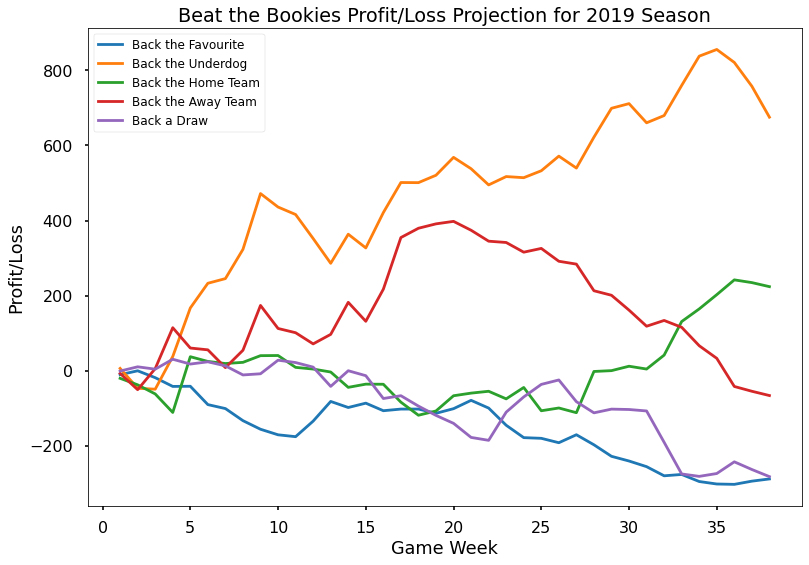

In [22]:
import matplotlib.style as style
style.use('seaborn-poster')
sns.lineplot(x='game_week', y='fav_profit', data=profits, label='Back the Favourite', ci=None)
sns.lineplot(x='game_week', y='underdog_profit', data=profits, label='Back the Underdog', ci=None)
sns.lineplot(x='game_week', y='home_profit', data=profits, label='Back the Home Team', ci=None)
sns.lineplot(x='game_week', y='away_profit', data=profits, label='Back the Away Team', ci=None)
sns.lineplot(x='game_week', y='draw_profit', data=profits, label='Back a Draw', ci=None)
# sns.lineplot(x='game_week', y='model_profit', data=profits, label='Model profit', ci=None)
plt.legend(fontsize='large', title_fontsize='40', loc='upper left')
plt.ylabel("Profit/Loss")
plt.xlabel("Game Week")
plt.title("Beat the Bookies Profit/Loss Projection for 2019 Season")

## Playing Around with Neural Networks

In [24]:
premier.columns.values

array(['season', 'date', 'home_team', 'away_team', 'home_team_goal',
       'away_team_goal', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee',
       'home_shots', 'away_shots', 'home_shots_ot', 'away_shots_ot',
       'home_fouls', 'away_fouls', 'home_corn', 'away_corn', 'home_yel',
       'away_yel', 'home_red', 'away_red', 'WHH', 'WHD', 'WHA', 'H_ATT',
       'H_MID', 'H_DEF', 'H_OVR', 'A_ATT', 'A_MID', 'A_DEF', 'A_OVR',
       'home_w', 'draw', 'away_w', 'winning_odds', 'home_t_home_goals',
       'home_t_home_goals_against', 'home_t_home_shots',
       'home_t_home_shots_ot', 'home_t_home_shots_against',
       'home_t_home_shots_ot_against', 'home_t_home_fouls',
       'home_t_home_fouls_against', 'home_t_home_corn',
       'home_t_home_corn_against', 'home_t_home_yel',
       'home_t_home_yel_against', 'home_t_home_red',
       'home_t_home_red_against', 'home_t_home_wins',
       'home_t_home_losses', 'home_t_home_draws', 'away_t_away_goals',
       'away_t_away_goals_against', 'away_t